<a href="https://colab.research.google.com/github/pratik1208/HealthProPred/blob/main/NN_target_Encoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df= pd.read_csv("/content/drive/MyDrive/Doceree-HCP_Train.csv",encoding='latin-1')

In [ ]:
df= pd.read_csv("/content/drive/MyDrive/Doceree-HCP_Train.csv",encoding='latin-1')

In [ ]:
df.columns

Index(['ID', 'DEVICETYPE', 'PLATFORM_ID', 'BIDREQUESTIP', 'USERPLATFORMUID',
       'USERCITY', 'USERZIPCODE', 'USERAGENT', 'PLATFORMTYPE', 'CHANNELTYPE',
       'URL', 'KEYWORDS', 'TAXONOMY', 'IS_HCP'],
      dtype='object')

In [ ]:
df['KEYWORDS'] =df['KEYWORDS'].str.lower()

In [ ]:
# data = df[['DEVICETYPE','USERCITY','USERZIPCODE','USERAGENT','PLATFORMTYPE','URL','IS_HCP']].fillna(0)
# columns = data.columns

In [ ]:
data = df.copy()

In [ ]:
data.drop(["TAXONOMY","KEYWORDS","CHANNELTYPE","PLATFORMTYPE","USERPLATFORMUID","BIDREQUESTIP","ID","PLATFORM_ID","DEVICETYPE"], axis=1, inplace=True)
data = data.fillna(0)

In [ ]:
columns = data.columns

In [ ]:
test = data.sample(20000,random_state=42)
train = data[~data.index.isin(test.index)]

#**Target Encoding**

In [ ]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.5 MB/s eta 0:00:00


In [ ]:
train_x = train.iloc[:,:-1]
train_y = train.iloc[:,-1]
test_x = test.iloc[:,:-1]
test_y = test.iloc[:,-1]

In [ ]:
import category_encoders as ce


#Create target encoding object
encoder=ce.TargetEncoder(cols=train_x.columns, smoothing=0.2)


In [ ]:
encoder

TargetEncoder(cols=Index(['USERCITY', 'USERZIPCODE', 'USERAGENT', 'URL'], dtype='object'),
              smoothing=0.2)

In [ ]:
train_x_encoded = encoder.fit_transform(train_x, train_y)
test_x_encoded =encoder.transform(test_x, test_y)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()

In [ ]:
dt.fit(train_x_encoded, train_y)
y_pred = dt.predict(test_x_encoded)
y_pred_train = dt.predict(train_x_encoded)

In [ ]:
from sklearn.metrics import f1_score, accuracy_score
print(f1_score(y_pred,test_y))
print(accuracy_score(y_pred,test_y))

0.9798055347793566
0.98785


In [ ]:
importance = dt.feature_importances_
feature_names = train_x.columns

In [ ]:
importance


array([0.02257857, 0.01533489, 0.12458294, 0.83750359])

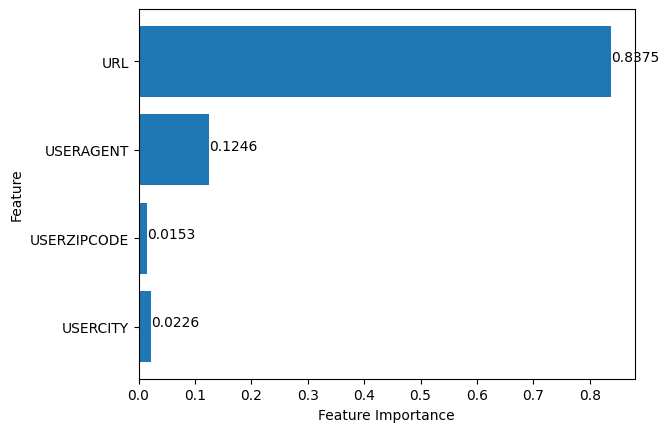

In [ ]:
import matplotlib.pyplot as plt
plt.barh(range(len(importance)), importance, align = 'center')
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.yticks(range(len(importance)), feature_names)
for index, value in enumerate(importance):
    plt.text(value, index, f'{value:.4f}')
plt.show()

**Count Vectorizer**

In [ ]:
train_x = train_x.join(df.KEYWORDS, how= 'left').copy()
test_x = test_x.join(df.KEYWORDS, how= 'left').copy()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features=514)


In [ ]:
vectorizer

CountVectorizer(max_features=514)

In [ ]:
train_x_sparse_matrix = vectorizer.fit_transform(train_x.KEYWORDS)
test_x_sparse_matrix = vectorizer.transform(test_x.KEYWORDS)

In [ ]:
feature_names = vectorizer.get_feature_names_out()


In [ ]:
test_x_sparse_matrix

<20000x514 sparse matrix of type '<class 'numpy.int64'>'
	with 717986 stored elements in Compressed Sparse Row format>

In [ ]:
df_train = pd.DataFrame(train_x_sparse_matrix.toarray(), columns=feature_names,index = train_x.index)
df_test = pd.DataFrame(test_x_sparse_matrix.toarray(), columns=feature_names,index = test_x.index)



In [ ]:
final_train = train_x_encoded.join(df_train, how='left')
final_test = test_x_encoded.join(df_test, how= 'left')

#**Neural Network**

In [ ]:
final_train.shape

(93937, 518)

In [ ]:
final_test.shape

(20000, 518)

In [ ]:
import torch
import torch.nn as nn
torch.manual_seed(0)


class NeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.ll = nn.Linear(518,256)
    self.ll2 = nn.Linear(256,128)
    self.ll3 = nn.Linear(128,64)
    self.ll4 = nn.Linear(64,32)
    self.ll5 = nn.Linear(32,16)
    self.ll6 = nn.Linear(16,8)
    self.ll7 = nn.Linear(8,4)
    self.ll8 = nn.Linear(4,2)
    self.ll9 = nn.Linear(2,1)
    self.leaky_relu  = nn.LeakyReLU(0.15)

  def forward(self,x):
    x =  self.leaky_relu(self.ll(x))
    x =  self.leaky_relu(self.ll2(x))
    x =  self.leaky_relu(self.ll3(x))
    x =  self.leaky_relu(self.ll4(x))
    x =  self.leaky_relu(self.ll5(x))
    x =  self.leaky_relu(self.ll6(x))
    x =  self.leaky_relu(self.ll7(x))
    x =  self.leaky_relu(self.ll8(x))
    x =  self.leaky_relu(self.ll9(x))
    x = torch.sigmoid(x)
    return x

torch.manual_seed(0)
neuralnet = NeuralNetwork()

In [ ]:
total_params = sum(p.numel() for p in neuralnet.parameters())
print(total_params)

176809


In [ ]:
with torch.no_grad():
    something = neuralnet(
      torch.randn(14,518)
    )
something

tensor([[0.4844],
        [0.4844],
        [0.4844],
        [0.4844],
        [0.4844],
        [0.4844],
        [0.4844],
        [0.4844],
        [0.4844],
        [0.4844],
        [0.4844],
        [0.4844],
        [0.4844],
        [0.4844]])

In [ ]:
final_train.shape

(93937, 518)

In [ ]:
train_y.shape

(93937,)

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader


class MyDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        return self.features.iloc[index,:].values, self.targets.iloc[index]




In [ ]:
from tqdm.notebook import tqdm
def evaluate(model,data_loader,device = 'cpu'):
    model = model.eval()
    with torch.inference_mode():
      preds, reals = [],[]
      for features, targets in tqdm(data_loader):
          pred = model(features.to(torch.float32).to(device))
          preds.append(pred.detach().cpu())
          reals.append(targets)
      pred = torch.cat(preds)>0.5
      real = torch.cat(reals)
      print(pred)
      print(real)
    print(
        "f1_score is =",
        f1_score(
            pred,real,average = "macro"
        )
    )
    print(
        "Accuracy is =",
        accuracy_score(
            pred,real
        )
    )
    model.train()


In [ ]:
# Create an instance of the dataset
features = final_train
targets = train_y

my_dataset = MyDataset(features, targets)

# Define a dataloader for the dataset
batch_size = 32
shuffle = True

my_dataloader = DataLoader(dataset=my_dataset, batch_size=batch_size, shuffle=shuffle)

In [ ]:
optimizer = torch.optim.Adam(neuralnet.parameters(), lr=0.001)

In [ ]:
device = torch.device('cuda')

In [ ]:
evaluate(neuralnet.to(device),my_dataloader,device)

  0%|          | 0/2936 [00:00<?, ?it/s]

tensor([[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]])
tensor([1., 1., 0.,  ..., 0., 0., 0.], dtype=torch.float64)
f1_score is = 0.4117871746222581
Accuracy is = 0.7000649371387206


In [ ]:
neuralnet.training

True

In [ ]:
import torch.nn as nn
from tqdm.notebook import tqdm
epochs = 10

loss = nn.BCELoss()
for epoch in tqdm(range(epochs)):

  for batch in tqdm(my_dataloader):
      batch_features, batch_targets = batch
      pred = neuralnet(batch_features.to(torch.float32).to(device))
      l = loss(pred.squeeze(), batch_targets.to(torch.float32).to(device) )
      print(f"\rloss = {l.item()}",end = ' ')
      optimizer.zero_grad()
      l.backward()
      optimizer.step()
  evaluate(neuralnet,my_dataloader,device)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2936 [00:00<?, ?it/s]

loss = 0.02179086208343506 

  0%|          | 0/2936 [00:00<?, ?it/s]

tensor([[ True],
        [ True],
        [ True],
        ...,
        [False],
        [False],
        [ True]])
tensor([1., 1., 1.,  ..., 0., 0., 1.], dtype=torch.float64)
f1_score is = 0.9808773326396698
Accuracy is = 0.9838189424827278


  0%|          | 0/2936 [00:00<?, ?it/s]

loss = 0.10739041864871979 

  0%|          | 0/2936 [00:00<?, ?it/s]

tensor([[ True],
        [False],
        [False],
        ...,
        [ True],
        [False],
        [ True]])
tensor([1., 0., 0.,  ..., 1., 0., 1.], dtype=torch.float64)
f1_score is = 0.9881739338385751
Accuracy is = 0.990110393135825


  0%|          | 0/2936 [00:00<?, ?it/s]

loss = 0.017854491248726845 

  0%|          | 0/2936 [00:00<?, ?it/s]

tensor([[False],
        [ True],
        [False],
        ...,
        [False],
        [False],
        [False]])
tensor([1., 1., 0.,  ..., 0., 0., 0.], dtype=torch.float64)
f1_score is = 0.9897353719874395
Accuracy is = 0.9914197813428148


  0%|          | 0/2936 [00:00<?, ?it/s]

loss = 0.0029290332458913326 

  0%|          | 0/2936 [00:00<?, ?it/s]

tensor([[False],
        [False],
        [False],
        ...,
        [ True],
        [False],
        [False]])
tensor([0., 0., 0.,  ..., 1., 0., 0.], dtype=torch.float64)
f1_score is = 0.990660427679446
Accuracy is = 0.9921756070557927


  0%|          | 0/2936 [00:00<?, ?it/s]

loss = 0.00029455081676132977 

  0%|          | 0/2936 [00:00<?, ?it/s]

tensor([[False],
        [False],
        [False],
        ...,
        [ True],
        [False],
        [ True]])
tensor([0., 0., 0.,  ..., 1., 0., 1.], dtype=torch.float64)
f1_score is = 0.992488824214893
Accuracy is = 0.9937191947794799


  0%|          | 0/2936 [00:00<?, ?it/s]

loss = 0.00010198234667768702 

  0%|          | 0/2936 [00:00<?, ?it/s]

tensor([[False],
        [False],
        [ True],
        ...,
        [ True],
        [False],
        [False]])
tensor([0., 0., 1.,  ..., 1., 0., 0.], dtype=torch.float64)
f1_score is = 0.994637676206544
Accuracy is = 0.9954969820198644


  0%|          | 0/2936 [00:00<?, ?it/s]

loss = 1.8531056866777362e-06 

  0%|          | 0/2936 [00:00<?, ?it/s]

tensor([[ True],
        [False],
        [False],
        ...,
        [ True],
        [False],
        [ True]])
tensor([1., 0., 0.,  ..., 1., 0., 1.], dtype=torch.float64)
f1_score is = 0.9947614654689461
Accuracy is = 0.9956034363456359


  0%|          | 0/2936 [00:00<?, ?it/s]

loss = 0.01334486622363329 

  0%|          | 0/2936 [00:00<?, ?it/s]

tensor([[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [ True]])
tensor([0., 0., 0.,  ..., 0., 0., 1.], dtype=torch.float64)
f1_score is = 0.9942429486181368
Accuracy is = 0.9951776190425498


  0%|          | 0/2936 [00:00<?, ?it/s]

loss = 6.877811301819747e-06 

  0%|          | 0/2936 [00:00<?, ?it/s]

tensor([[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [ True]])
tensor([0., 0., 0.,  ..., 0., 0., 1.], dtype=torch.float64)
f1_score is = 0.9958304036263762
Accuracy is = 0.9964976526821168


  0%|          | 0/2936 [00:00<?, ?it/s]

loss = 0.00013497636246029288 

  0%|          | 0/2936 [00:00<?, ?it/s]

tensor([[ True],
        [False],
        [False],
        ...,
        [False],
        [ True],
        [False]])
tensor([1., 0., 0.,  ..., 0., 1., 0.], dtype=torch.float64)
f1_score is = 0.995108043359514
Accuracy is = 0.9959015084577962


In [ ]:
evaluate(neuralnet,my_dataloader,device)

  0%|          | 0/2936 [00:00<?, ?it/s]

tensor([[ True],
        [ True],
        [False],
        ...,
        [False],
        [False],
        [False]])
tensor([1., 1., 0.,  ..., 0., 0., 0.], dtype=torch.float64)
f1_score is = 0.995108043359514
Accuracy is = 0.9959015084577962


In [ ]:
test_features = final_test
test_target = test_y
my_dataset_test = MyDataset(test_features, test_target)
# Define a dataloader for the dataset
batch_size = 32
shuffle = True

my_dataloader_test = DataLoader(dataset=my_dataset, batch_size=batch_size, shuffle=shuffle)

In [ ]:
import torch.nn as nn
from tqdm.notebook import tqdm
epochs = 1
optimizer = torch.optim.Adam(neuralnet.parameters(), lr=0.001)
loss = nn.BCELoss()
for epoch in tqdm(range(epochs)):

  for batch in tqdm(my_dataloader_test):
      batch_features, batch_targets = batch
      pred = neuralnet(batch_features.to(torch.float32).to(device))
      l = loss(pred.squeeze(), batch_targets.to(torch.float32).to(device))
      print(f"\rloss = {l.item()}",end = ' ')
      l.backward()
      optimizer.step()
      optimizer.zero_grad()
  evaluate(neuralnet,my_dataloader_test,device)



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2936 [00:00<?, ?it/s]

loss = 6.546812528540613e-06 

  0%|          | 0/2936 [00:00<?, ?it/s]

tensor([[False],
        [ True],
        [False],
        ...,
        [ True],
        [False],
        [ True]])
tensor([0., 1., 0.,  ..., 1., 0., 1.], dtype=torch.float64)
f1_score is = 0.9948116741429684
Accuracy is = 0.9956460180759445


In [ ]:
batch_targets.to(torch.long)

In [ ]:
loss(pred.squeeze(), batch_targets.to(torch.float32) )

In [ ]:
from sklearn.metrics import f1_score
f1_score(
    torch.cat(real),
    (torch.cat(predict)>0.5).to(torch.long),
    average = 'macro'
)

In [ ]:
a = None
if not a:
    print ("Lassun")

Lassun


In [ ]:
batch_targets

tensor([0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1.,
        1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
        0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0.,
        1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
        1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1.,
        0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0.,
        0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 

In [ ]:
class dumy:
    def __init__(self):
        self.value = 10
    def __getitem__(self,index):
        print("index = ",index)
        print("value = ",self.value)
d = dumy()

In [ ]:
d[(100)]

index =  100
value =  10


In [ ]:
real = [
    torch.tensor([[1.],[0],[1],[0]]),
    torch.tensor([[1],[0],[0.0],[0]]),
    torch.tensor([[1],[0],[0.0],[1.0]])
]
pred = [
    torch.tensor([[0.5],[0.2],[0.6],[0.2]]),
    torch.tensor([[0.7],[0.2],[0.6],[0.2]]),
    torch.tensor([[0.2],[0.2],[0.6],[0.6]]),
]

In [ ]:
torch.stack([real[0], real[1]]).shape

torch.Size([2, 4, 1])

In [ ]:
real[0]

tensor([[1.],
        [0.],
        [1.],
        [0.]])

In [ ]:
torch.cat(real)

tensor([[1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.]])

In [ ]:
torch.cat(real).shape

torch.Size([12, 1])

In [ ]:
from sklearn.metrics import f1_score
f1_score(
    torch.cat(real),
    (torch.cat(pred)>0.5).to(torch.long),
    average = 'macro'
)

0.6571428571428571

In [ ]:
(torch.cat(pred)>0.5).to(torch.long)

tensor([[0],
        [0],
        [1],
        [0],
        [1],
        [0],
        [1],
        [0],
        [0],
        [0],
        [1],
        [1]])

In [ ]:
torch.randn((1,2))

tensor([[ 0.2953, -0.2055]])

In [ ]:
torch.tensor([
    [1,2],
    [1]
])

ValueError: expected sequence of length 2 at dim 1 (got 1)

In [ ]:
[
    [1,2],
    [1]
]

[[1, 2], [1]]

In [ ]:
a = [1,2]
b = [2,3]
c = [4,5]


In [ ]:
d = [a,c]

In [ ]:
id(d)

139414083996288

In [ ]:
id(d[0]),id(a)

(139414083999360, 139414083999360)

In [ ]:
d[0][0] = 5

In [ ]:
a = np.array([1,2])
b = np.array([a,[2,3]])

In [ ]:
b[0][0] = 2

In [ ]:
b

array([[2, 2],
       [2, 3]])

In [ ]:
a

array([1, 2])

In [ ]:
import numpy as np
np.array(
    [
        [1,2],
        [1]
    ]
)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.